In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (KFold, ShuffleSplit,
                                     StratifiedKFold, 
                                     StratifiedShuffleSplit)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [3]:
hf = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

In [4]:
pred_vars = ['age', 'sex', 'smoking', 'diabetes', 'serum_creatinine', 'ejection_fraction']

In [5]:
def visualize_groups(classes):
    # Visualize dataset groups
    cmap_data = plt.cm.Paired
    fig, ax = plt.subplots()
    ax.scatter(range(len(classes)),  [2] * len(classes), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[2],
           yticklabels=['Data\nclass'], xlabel="Sample index")

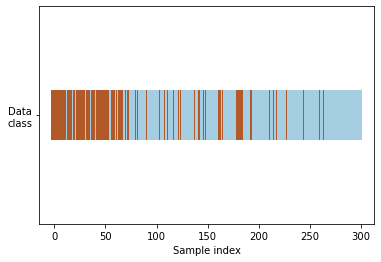

In [23]:
visualize_groups(hf['DEATH_EVENT'])

In [6]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        #print(ii)
        #print(tt, tr)
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        #print(indices)
        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)



    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
    plt.show()
    return ax

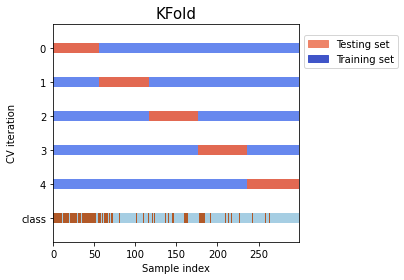

<AxesSubplot:title={'center':'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

In [7]:
# define number of folds
n_splits = 5

# create empty plot
fig, ax = plt.subplots()
# get subset folds
cv = KFold(n_splits)
# call plot function
plot_cv_indices(cv, hf[pred_vars], hf['DEATH_EVENT'], ax, n_splits)

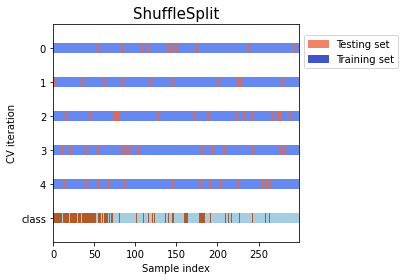

<AxesSubplot:title={'center':'ShuffleSplit'}, xlabel='Sample index', ylabel='CV iteration'>

In [8]:
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits)
plot_cv_indices(cv, hf[pred_vars], hf['DEATH_EVENT'], ax, n_splits)

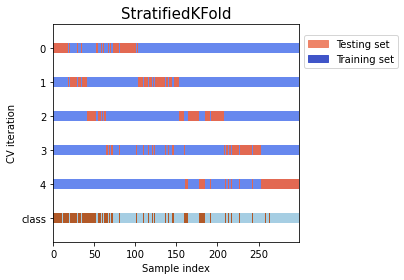

<AxesSubplot:title={'center':'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

In [9]:
fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits)
plot_cv_indices(cv, hf[pred_vars], hf['DEATH_EVENT'], ax, n_splits)

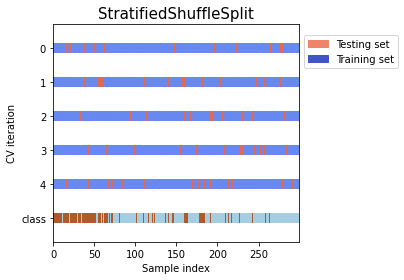

<AxesSubplot:title={'center':'StratifiedShuffleSplit'}, xlabel='Sample index', ylabel='CV iteration'>

In [10]:
# stratified with randomization
fig, ax = plt.subplots()
cv = StratifiedShuffleSplit(n_splits)
plot_cv_indices(cv, hf[pred_vars], hf['DEATH_EVENT'], ax, n_splits)

In [11]:
np.random.seed(516)

# create train and test
train, test = train_test_split(hf, test_size=0.20, stratify=hf['DEATH_EVENT'])
print("Rows in train:", len(train))
print("Rows in test:", len(test))

# view some stats by different variables
train_stats = train.groupby('DEATH_EVENT')[['age', 'sex', 'diabetes']].agg(['mean', 'count'])
print("Training data:\n", train_stats)
test_stats = test.groupby('DEATH_EVENT')[['age', 'sex', 'diabetes']].agg(['mean', 'count'])
print("Testing data:\n", test_stats)

Rows in train: 239
Rows in test: 60
Training data:
                    age             sex        diabetes      
                  mean count      mean count      mean count
DEATH_EVENT                                                 
0            58.775722   162  0.623457   162  0.407407   162
1            65.359312    77  0.649351    77  0.428571    77
Testing data:
                    age             sex        diabetes      
                  mean count      mean count      mean count
DEATH_EVENT                                                 
0            58.707317    41  0.756098    41  0.463415    41
1            64.631579    19  0.631579    19  0.368421    19


In [12]:
scoring = ['accuracy', 'neg_log_loss', 'f1', 'roc_auc']
rf_base = RandomForestClassifier()
cv_rf = cross_validate(rf_base, train[pred_vars], train['DEATH_EVENT'], cv=StratifiedShuffleSplit(n_splits), scoring=scoring)
print(cv_rf)

{'fit_time': array([0.16906714, 0.14512467, 0.12799954, 0.12800002, 0.12400031]), 'score_time': array([0.03925443, 0.02800035, 0.02400017, 0.02399969, 0.02400017]), 'test_accuracy': array([0.75      , 0.70833333, 0.70833333, 0.75      , 0.79166667]), 'test_neg_log_loss': array([-0.45161806, -0.51007159, -0.57957598, -0.46577141, -0.48167848]), 'test_f1': array([0.57142857, 0.46153846, 0.58823529, 0.57142857, 0.70588235]), 'test_roc_auc': array([0.828125  , 0.80078125, 0.73828125, 0.84765625, 0.796875  ])}


In [13]:
# view a single statistic over the models
print(cv_rf['test_roc_auc'])
print("mean model AUC", np.mean(cv_rf['test_roc_auc']))

[0.828125   0.80078125 0.73828125 0.84765625 0.796875  ]
mean model AUC 0.80234375


In [14]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, None]}

In [15]:
rf_base = RandomForestClassifier()
rf_tuned = GridSearchCV(rf_base, param_grid=params, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
rf_tuned.fit(train[pred_vars], train['DEATH_EVENT'])

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None]},
             scoring='roc_auc')

In [16]:
print(rf_tuned.cv_results_)

{'mean_fit_time': array([0.12839851, 0.15328231, 0.12443008, 0.15401073, 0.1414825 ,
       0.1369658 , 0.13460722, 0.1296308 ]), 'std_fit_time': array([0.011458  , 0.04188973, 0.00394965, 0.01533285, 0.00367232,
       0.00722234, 0.00830084, 0.00411101]), 'mean_score_time': array([0.01200137, 0.01438293, 0.01185794, 0.01365223, 0.02583575,
       0.01202369, 0.01098557, 0.01041403]), 'std_score_time': array([2.53001706e-03, 3.17715955e-03, 3.32160479e-04, 1.50565443e-03,
       2.17348670e-02, 4.67327176e-05, 1.52984931e-03, 1.94495747e-03]), 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'entropy', 'entropy',
                   'entropy', 'entropy'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 10, 15, None, 5, 10, 15, None],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype

In [18]:
import warnings
warnings.filterwarnings('ignore')

nnet_base = MLPClassifier()

params = {'hidden_layer_sizes': [(100,), (10,10), (5,5,5)], 
          'solver': ['adam', 'lbfgs', 'sgd']}
# 9 different param combos, 5 cv = total of 45 models
# try with differnt scoring methods
# we get different results with accuracy & log_loss
nnet_tuned = GridSearchCV(nnet_base, param_grid=params, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
nnet_tuned.fit(train[pred_vars], train['DEATH_EVENT'])
# nnet_tuned.get_params()
print(nnet_tuned.cv_results_)

{'mean_fit_time': array([0.16518078, 0.18278918, 0.04851022, 0.14372883, 0.12489467,
       0.04727702, 0.11321507, 0.07985001, 0.09447598]), 'std_fit_time': array([0.03979137, 0.01119646, 0.01984361, 0.02909025, 0.01171174,
       0.01376896, 0.05878644, 0.04343071, 0.05238494]), 'mean_score_time': array([0.00240011, 0.00239148, 0.00479417, 0.00311713, 0.00365763,
       0.00258179, 0.00237746, 0.0024272 , 0.00320339]), 'std_score_time': array([0.00195968, 0.0019527 , 0.00160322, 0.00157483, 0.00203689,
       0.0014626 , 0.0019412 , 0.00198209, 0.00160172]), 'param_hidden_layer_sizes': masked_array(data=[(100,), (100,), (100,), (10, 10), (10, 10), (10, 10),
                   (5, 5, 5), (5, 5, 5), (5, 5, 5)],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['adam', 'lbfgs', 'sgd', 'adam', 'lbfgs', 'sgd', 'adam',
                   'lbfgs', 'sgd'],


In [19]:
print(nnet_tuned.cv_results_['mean_test_score'])

[0.7328125 0.6953125 0.71875   0.7359375 0.7578125 0.753125  0.7171875
 0.6984375 0.6375   ]


In [20]:
print(nnet_tuned.best_estimator_)

MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs')


In [21]:
fitted = [rf_tuned, nnet_tuned]

result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in fitted:
    print(clf.estimator)
    yproba = clf.predict_proba(test[pred_vars])
    yclass = clf.predict(test[pred_vars])
    
    # auc information
    fpr, tpr, _ = metrics.roc_curve(test['DEATH_EVENT'],  yproba[:,1])
    auc = metrics.roc_auc_score(test['DEATH_EVENT'], yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test['DEATH_EVENT'], yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test['DEATH_EVENT'], yclass)
    
    
    result_table = result_table.append({'classifier_name':str(clf.estimator),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)
    


result_table.set_index('classifier_name', inplace=True)
# print(result_table)

RandomForestClassifier()
MLPClassifier()


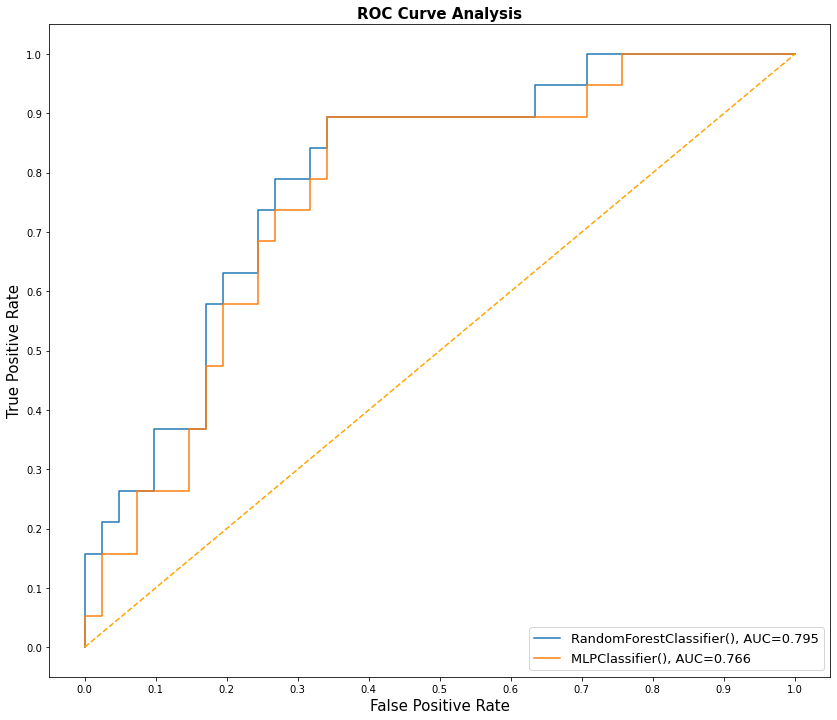

In [22]:
fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [24]:
for i in result_table.index:
        print('\n---- statistics for', i, '----\n')
        print(result_table.loc[i, 'clf_report'])
        print('Model log loss:', result_table.loc[i, 'log_loss'])


---- statistics for RandomForestClassifier() ----

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        41
           1       0.61      0.58      0.59        19

    accuracy                           0.75        60
   macro avg       0.71      0.70      0.71        60
weighted avg       0.75      0.75      0.75        60

Model log loss: 0.5049535578851839

---- statistics for MLPClassifier() ----

              precision    recall  f1-score   support

           0       0.84      0.76      0.79        41
           1       0.57      0.68      0.62        19

    accuracy                           0.73        60
   macro avg       0.70      0.72      0.71        60
weighted avg       0.75      0.73      0.74        60

Model log loss: 0.537567747838826


# Tasks

1. Tune the parameters for two additional algorithms. They can be those which were used in last lab, or you can try some other algorithm. A list of the models in sklearn is here. Use a grid search on at least two different parameters for each model. For example, in the random forest built in the lab, we modified the criterion and max_depth parameters.

        a. You should now have four models to compare. Which model performs best on out-of-sample (test) data? Include precision, recall, accuracy, F1, and ROC/AUC when deciding.

2. Use all of the available columns for the prediction. How well do the models perform with all columns?

# Task 1 

In [25]:
#Going to use GaussianNB and KNeighborsClassifier

# create train and test
train, test = train_test_split(hf, test_size=0.20, stratify=hf['DEATH_EVENT'])
print("Rows in train:", len(train))
print("Rows in test:", len(test))

# view some stats by different variables
train_stats = train.groupby('DEATH_EVENT')[['age', 'sex', 'diabetes']].agg(['mean', 'count'])
print("Training data:\n", train_stats)
test_stats = test.groupby('DEATH_EVENT')[['age', 'sex', 'diabetes']].agg(['mean', 'count'])
print("Testing data:\n", test_stats)

Rows in train: 239
Rows in test: 60
Training data:
                   age             sex        diabetes      
                 mean count      mean count      mean count
DEATH_EVENT                                                
0            58.88066   162  0.641975   162  0.432099   162
1            66.06061    77  0.675325    77  0.402597    77
Testing data:
                    age             sex        diabetes      
                  mean count      mean count      mean count
DEATH_EVENT                                                 
0            58.292683    41  0.682927    41  0.365854    41
1            61.789474    19  0.526316    19  0.473684    19


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [48]:
scoring = ['accuracy', 'neg_log_loss', 'f1', 'roc_auc']
lr_base = LogisticRegression()
cv_lr = cross_validate(lr_base, train[pred_vars], train['DEATH_EVENT'], cv=StratifiedShuffleSplit(n_splits), scoring=scoring)
print(cv_lr)

{'fit_time': array([0.01994753, 0.01894641, 0.01495934, 0.01894951, 0.01396275]), 'score_time': array([0.00698113, 0.00698233, 0.00598311, 0.00498581, 0.00598311]), 'test_accuracy': array([0.70833333, 0.70833333, 0.83333333, 0.70833333, 0.83333333]), 'test_neg_log_loss': array([-0.49136326, -0.60956493, -0.43390203, -0.59511758, -0.50788255]), 'test_f1': array([0.46153846, 0.36363636, 0.71428571, 0.36363636, 0.71428571]), 'test_roc_auc': array([0.8046875, 0.6640625, 0.875    , 0.65625  , 0.7734375])}


In [43]:
scoring = ['accuracy', 'neg_log_loss', 'f1', 'roc_auc']
KNC_base = KNeighborsClassifier()
cv_KNC = cross_validate(KNC_base, train[pred_vars], train['DEATH_EVENT'], cv=StratifiedShuffleSplit(n_splits), scoring=scoring)
print(cv_KNC)

{'fit_time': array([0.00498629, 0.00202799, 0.00299168, 0.002985  , 0.00299144]), 'score_time': array([0.00698185, 0.00993896, 0.00598431, 0.0069809 , 0.00598407]), 'test_accuracy': array([0.66666667, 0.58333333, 0.625     , 0.54166667, 0.70833333]), 'test_neg_log_loss': array([-4.74019786, -1.96723851, -1.89306615, -4.83086065, -1.85927739]), 'test_f1': array([0.2       , 0.28571429, 0.30769231, 0.15384615, 0.53333333]), 'test_roc_auc': array([0.48046875, 0.640625  , 0.703125  , 0.60546875, 0.75390625])}


In [49]:
# view a single statistic over the models
print(cv_lr['test_roc_auc'])
print("mean model AUC", np.mean(cv_lr['test_roc_auc']))

[0.8046875 0.6640625 0.875     0.65625   0.7734375]
mean model AUC 0.7546875


In [45]:
# view a single statistic over the models
print(cv_KNC['test_roc_auc'])
print("mean model AUC", np.mean(cv_KNC['test_roc_auc']))

[0.48046875 0.640625   0.703125   0.60546875 0.75390625]
mean model AUC 0.63671875


In [52]:
params_lr = {'penalty': ['l2', 'elasticnet', 'none'], 'C': [1.0, 2.0], 'class_weight': ['balanced',None]}
params_KNC = {'n_neighbors': [2, 5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree'], 'leaf_size':[2,5]}

In [54]:
lr_base = LogisticRegression()
lr_tuned = GridSearchCV(lr_base, param_grid=params_lr, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
lr_tuned.fit(train[pred_vars], train['DEATH_EVENT'])
print(lr_tuned.cv_results_)

{'mean_fit_time': array([0.01376758, 0.00039883, 0.0127646 , 0.01376076, 0.00059853,
       0.01675582, 0.01297174, 0.00059857, 0.01216803, 0.01436238,
       0.0011972 , 0.01456017]), 'std_fit_time': array([0.00213175, 0.00048846, 0.00171514, 0.00171737, 0.00048869,
       0.00222212, 0.00200658, 0.00048873, 0.00193346, 0.00205365,
       0.00039978, 0.001027  ]), 'mean_score_time': array([0.00279217, 0.        , 0.00229635, 0.00279484, 0.        ,
       0.00199389, 0.00218716, 0.        , 0.00199523, 0.00219393,
       0.        , 0.00219531]), 'std_score_time': array([7.57406578e-04, 0.00000000e+00, 3.98861488e-04, 7.46968454e-04,
       0.00000000e+00, 1.09776158e-06, 3.86405914e-04, 0.00000000e+00,
       2.96867035e-06, 3.98874297e-04, 0.00000000e+00, 4.02593655e-04]), 'param_C': masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,
                   2.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, Fa

In [57]:
KNC_base = KNeighborsClassifier()
KNC_tuned = GridSearchCV(KNC_base, param_grid=params_KNC, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
KNC_tuned.fit(train[pred_vars], train['DEATH_EVENT'])
print(KNC_tuned.cv_results_)

{'mean_fit_time': array([0.00379663, 0.00219431, 0.00199018, 0.00239882, 0.00259328,
       0.00239339, 0.0023941 , 0.0027925 , 0.00239367, 0.00239363,
       0.0023942 , 0.00278649, 0.00239129, 0.00259433, 0.00257707,
       0.00239234, 0.00338111, 0.00179491, 0.00219178, 0.00259199,
       0.00219064, 0.0019938 , 0.00238957, 0.00239358, 0.00239701,
       0.00199947, 0.00199494, 0.00179605, 0.00218921, 0.0021956 ,
       0.00178833, 0.00199456]), 'std_fit_time': array([7.40698103e-04, 3.98922736e-04, 8.87301577e-06, 4.89368606e-04,
       4.88227417e-04, 4.88694666e-04, 4.88694480e-04, 7.46646578e-04,
       4.89531844e-04, 4.88402903e-04, 4.88714053e-04, 7.54240807e-04,
       4.86231096e-04, 4.89379153e-04, 8.04906745e-04, 4.88201788e-04,
       2.32451269e-03, 3.99041585e-04, 3.99973811e-04, 4.89319702e-04,
       7.42602075e-04, 4.67203091e-07, 4.90778645e-04, 4.88441635e-04,
       4.99782927e-04, 1.07034807e-05, 6.30977238e-04, 7.47130904e-04,
       3.90148425e-04, 4.01854724e

In [59]:
fitted = [lr_tuned, KNC_tuned, rf_tuned, nnet_tuned]

result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in fitted:
    print(clf.estimator)
    yproba = clf.predict_proba(test[pred_vars])
    yclass = clf.predict(test[pred_vars])
    
    # auc information
    fpr, tpr, _ = metrics.roc_curve(test['DEATH_EVENT'],  yproba[:,1])
    auc = metrics.roc_auc_score(test['DEATH_EVENT'], yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test['DEATH_EVENT'], yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test['DEATH_EVENT'], yclass)
    
    
    result_table = result_table.append({'classifier_name':str(clf.estimator),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)
    


result_table.set_index('classifier_name', inplace=True)
# print(result_table)

LogisticRegression()
KNeighborsClassifier()
RandomForestClassifier()
MLPClassifier()


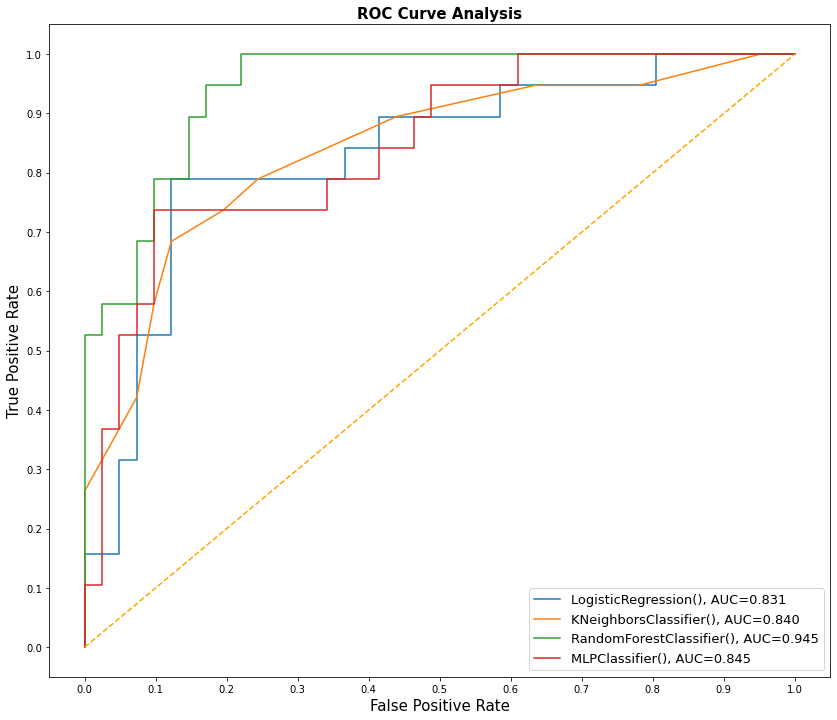

In [60]:
fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [61]:
for i in result_table.index:
        print('\n---- statistics for', i, '----\n')
        print(result_table.loc[i, 'clf_report'])
        print('Model log loss:', result_table.loc[i, 'log_loss'])


---- statistics for LogisticRegression() ----

              precision    recall  f1-score   support

           0       0.81      0.93      0.86        41
           1       0.77      0.53      0.62        19

    accuracy                           0.80        60
   macro avg       0.79      0.73      0.74        60
weighted avg       0.80      0.80      0.79        60

Model log loss: 0.46517728036349115

---- statistics for KNeighborsClassifier() ----

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        41
           1       0.73      0.58      0.65        19

    accuracy                           0.80        60
   macro avg       0.78      0.74      0.75        60
weighted avg       0.79      0.80      0.79        60

Model log loss: 0.4641026990406234

---- statistics for RandomForestClassifier() ----

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        41
           1    

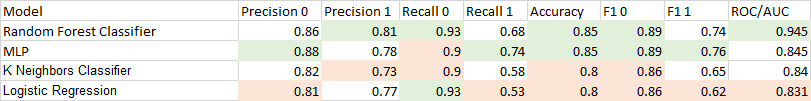

By comparing the models we can easily tell which performed the worst that was the Logistical Regression model. However, to tell which is the best is a little harder the Random Forest Classifier and MLP statistics are almost identical. The random Forest Classifier has a better area under the curve than MLP by .1. For this reason I believe the Random Forest Clasifier model is the best.

# Task 2

In [62]:
hf.columns.tolist()

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'DEATH_EVENT']

In [63]:
full_pred_col = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure',
 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',]

In [64]:
np.random.seed(516)

# create train and test
train, test = train_test_split(hf, test_size=0.20, stratify=hf['DEATH_EVENT'])
print("Rows in train:", len(train))
print("Rows in test:", len(test))

# view some stats by different variables
train_stats = train.groupby('DEATH_EVENT')[['age', 'sex', 'diabetes']].agg(['mean', 'count'])
print("Training data:\n", train_stats)
test_stats = test.groupby('DEATH_EVENT')[['age', 'sex', 'diabetes']].agg(['mean', 'count'])
print("Testing data:\n", test_stats)

Rows in train: 239
Rows in test: 60
Training data:
                    age             sex        diabetes      
                  mean count      mean count      mean count
DEATH_EVENT                                                 
0            58.775722   162  0.623457   162  0.407407   162
1            65.359312    77  0.649351    77  0.428571    77
Testing data:
                    age             sex        diabetes      
                  mean count      mean count      mean count
DEATH_EVENT                                                 
0            58.707317    41  0.756098    41  0.463415    41
1            64.631579    19  0.631579    19  0.368421    19


In [65]:
scoring = ['accuracy', 'neg_log_loss', 'f1', 'roc_auc']
rf_base = RandomForestClassifier()
cv_rf = cross_validate(rf_base, train[full_pred_col], train['DEATH_EVENT'], cv=StratifiedShuffleSplit(n_splits), scoring=scoring)
print(cv_rf)

{'fit_time': array([0.11629009, 0.09424925, 0.09616709, 0.09296417, 0.10095167]), 'score_time': array([0.01898766, 0.01695299, 0.01701832, 0.01896954, 0.0179522 ]), 'test_accuracy': array([0.91666667, 0.95833333, 0.91666667, 0.875     , 0.83333333]), 'test_neg_log_loss': array([-0.27048696, -0.27224007, -0.24548403, -0.35949615, -0.34810464]), 'test_f1': array([0.88888889, 0.93333333, 0.875     , 0.8       , 0.66666667]), 'test_roc_auc': array([1.       , 0.96875  , 0.9921875, 0.9140625, 0.9375   ])}


In [72]:
scoring = ['accuracy', 'neg_log_loss', 'f1', 'roc_auc']
rf_base = MLPClassifier()
cv_rf = cross_validate(rf_base, train[full_pred_col], train['DEATH_EVENT'], cv=StratifiedShuffleSplit(n_splits), scoring=scoring)
print(cv_rf)

{'fit_time': array([0.01795197, 0.01595902, 0.0209465 , 0.01397038, 0.02194166]), 'score_time': array([0.00598383, 0.00498581, 0.00599313, 0.00497723, 0.00698161]), 'test_accuracy': array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]), 'test_neg_log_loss': array([-11.51292546, -11.51292546, -11.51292546, -11.51292546,
       -11.51292546]), 'test_f1': array([0., 0., 0., 0., 0.]), 'test_roc_auc': array([0.5      , 0.5      , 0.5078125, 0.5      , 0.5      ])}


In [73]:
scoring = ['accuracy', 'neg_log_loss', 'f1', 'roc_auc']
lr_base = LogisticRegression()
cv_lr = cross_validate(lr_base, train[full_pred_col], train['DEATH_EVENT'], cv=StratifiedShuffleSplit(n_splits), scoring=scoring)
print(cv_lr)

{'fit_time': array([0.02259779, 0.01683903, 0.01791883, 0.01297379, 0.01695275]), 'score_time': array([0.00597477, 0.00502038, 0.00601721, 0.00597572, 0.00598454]), 'test_accuracy': array([0.91666667, 0.95833333, 0.83333333, 0.875     , 0.875     ]), 'test_neg_log_loss': array([-0.2592639 , -0.26313438, -0.53998012, -0.40363511, -0.39491306]), 'test_f1': array([0.85714286, 0.93333333, 0.75      , 0.82352941, 0.8       ]), 'test_roc_auc': array([0.9765625, 0.984375 , 0.828125 , 0.8828125, 0.890625 ])}


In [74]:
scoring = ['accuracy', 'neg_log_loss', 'f1', 'roc_auc']
KNC_base = KNeighborsClassifier()
cv_KNC = cross_validate(KNC_base, train[full_pred_col], train['DEATH_EVENT'], cv=StratifiedShuffleSplit(n_splits), scoring=scoring)
print(cv_KNC)

{'fit_time': array([0.00299239, 0.00299263, 0.00199461, 0.00199461, 0.00199437]), 'score_time': array([0.00997138, 0.00797892, 0.00797939, 0.00498676, 0.00698137]), 'test_accuracy': array([0.5       , 0.5       , 0.70833333, 0.625     , 0.58333333]), 'test_neg_log_loss': array([-2.06045713, -3.50546863, -1.99019051, -2.14880144, -2.07905243]), 'test_f1': array([0.14285714, 0.14285714, 0.22222222, 0.18181818, 0.        ]), 'test_roc_auc': array([0.50390625, 0.45703125, 0.5546875 , 0.3984375 , 0.4296875 ])}


In [85]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, None]}
rf_base = RandomForestClassifier()
rf_tuned = GridSearchCV(rf_base, param_grid=params, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
rf_tuned.fit(train[full_pred_col], train['DEATH_EVENT'])

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None]},
             scoring='roc_auc')

In [86]:
import warnings
warnings.filterwarnings('ignore')

nnet_base = MLPClassifier()

params = {'hidden_layer_sizes': [(100,), (10,10), (5,5,5)], 
          'solver': ['adam', 'lbfgs', 'sgd']}
# 9 different param combos, 5 cv = total of 45 models
# try with differnt scoring methods
# we get different results with accuracy & log_loss
nnet_tuned = GridSearchCV(nnet_base, param_grid=params, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
nnet_tuned.fit(train[full_pred_col], train['DEATH_EVENT'])
# nnet_tuned.get_params()
print(nnet_tuned.cv_results_)

{'mean_fit_time': array([0.0154635 , 0.01476097, 0.0117681 , 0.01456146, 0.01486139,
       0.01057167, 0.02753282, 0.01475067, 0.01077094]), 'std_fit_time': array([0.00223516, 0.00116299, 0.00116291, 0.00645226, 0.00493362,
       0.00079737, 0.02667961, 0.0135835 , 0.00073872]), 'mean_score_time': array([0.00239763, 0.00219378, 0.00239382, 0.00199399, 0.00259218,
       0.00219479, 0.00199471, 0.00259705, 0.00199461]), 'std_score_time': array([4.87204212e-04, 3.99184437e-04, 4.88733468e-04, 1.26698782e-06,
       4.88015113e-04, 3.99279634e-04, 1.74290341e-06, 8.05311632e-04,
       2.70581454e-06]), 'param_hidden_layer_sizes': masked_array(data=[(100,), (100,), (100,), (10, 10), (10, 10), (10, 10),
                   (5, 5, 5), (5, 5, 5), (5, 5, 5)],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['adam', 'lbfgs', 'sgd', 'adam', 'lbfgs', 'sgd', '

In [87]:
params_lr = {'penalty': ['l2', 'elasticnet', 'none'], 'C': [1.0, 2.0], 'class_weight': ['balanced',None]}
params_KNC = {'n_neighbors': [2, 5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree'], 'leaf_size':[2,5]}

In [88]:
lr_base = LogisticRegression()
lr_tuned = GridSearchCV(lr_base, param_grid=params_lr, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
lr_tuned.fit(train[full_pred_col], train['DEATH_EVENT'])
print(lr_tuned.cv_results_)

{'mean_fit_time': array([0.01615534, 0.00059838, 0.01814299, 0.01666951, 0.00039902,
       0.01554294, 0.01536636, 0.00019946, 0.0165555 , 0.01436229,
       0.        , 0.01505032]), 'std_fit_time': array([0.0019343 , 0.00048858, 0.00145982, 0.00278631, 0.00048869,
       0.00286865, 0.0020492 , 0.00039892, 0.00119693, 0.00239917,
       0.        , 0.00294039]), 'mean_score_time': array([0.00299215, 0.        , 0.00240135, 0.00238781, 0.        ,
       0.00240264, 0.00199347, 0.        , 0.0017951 , 0.00199409,
       0.        , 0.00239406]), 'std_score_time': array([1.09502227e-03, 0.00000000e+00, 4.97357820e-04, 8.00335245e-04,
       0.00000000e+00, 7.84488771e-04, 2.69486831e-06, 0.00000000e+00,
       3.98898848e-04, 1.42573513e-06, 0.00000000e+00, 7.98416650e-04]), 'param_C': masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,
                   2.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, Fa

In [89]:
KNC_base = KNeighborsClassifier()
KNC_tuned = GridSearchCV(KNC_base, param_grid=params_KNC, cv=StratifiedShuffleSplit(n_splits), scoring='roc_auc')
KNC_tuned.fit(train[full_pred_col], train['DEATH_EVENT'])
print(KNC_tuned.cv_results_)

{'mean_fit_time': array([0.00300655, 0.00239339, 0.00259266, 0.00199485, 0.00199618,
       0.00200195, 0.00239401, 0.00238881, 0.00199461, 0.00218234,
       0.00199456, 0.00199404, 0.00199566, 0.00199466, 0.00219383,
       0.00220084, 0.00179586, 0.00200081, 0.00199475, 0.0017952 ,
       0.00198874, 0.00199485, 0.00199032, 0.00179482, 0.00178657,
       0.00218539, 0.00159006, 0.00219359, 0.00219417, 0.00179338,
       0.00179505, 0.00178375]), 'std_fit_time': array([1.08291059e-03, 4.88791874e-04, 4.87820554e-04, 3.69356475e-07,
       2.21668256e-05, 1.26216913e-05, 4.88091931e-04, 4.93300257e-04,
       3.98950589e-07, 4.04786460e-04, 2.78041453e-07, 1.49729905e-06,
       1.95110904e-05, 4.62310777e-07, 4.00352932e-04, 3.95260356e-04,
       3.99286040e-04, 1.23996000e-05, 4.42200589e-07, 3.98826628e-04,
       1.22126179e-05, 6.30901855e-04, 1.02047608e-05, 3.83106743e-04,
       3.94728685e-04, 3.87893983e-04, 8.02694781e-04, 3.99643609e-04,
       3.99113015e-04, 3.97833445e

In [90]:
fitted = [lr_tuned, KNC_tuned, rf_tuned, nnet_tuned]

result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in fitted:
    print(clf.estimator)
    yproba = clf.predict_proba(test[full_pred_col])
    yclass = clf.predict(test[full_pred_col])
    
    # auc information
    fpr, tpr, _ = metrics.roc_curve(test['DEATH_EVENT'],  yproba[:,1])
    auc = metrics.roc_auc_score(test['DEATH_EVENT'], yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test['DEATH_EVENT'], yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test['DEATH_EVENT'], yclass)
    
    
    result_table = result_table.append({'classifier_name':str(clf.estimator),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)
    


result_table.set_index('classifier_name', inplace=True)
# print(result_table)

LogisticRegression()
KNeighborsClassifier()
RandomForestClassifier()
MLPClassifier()


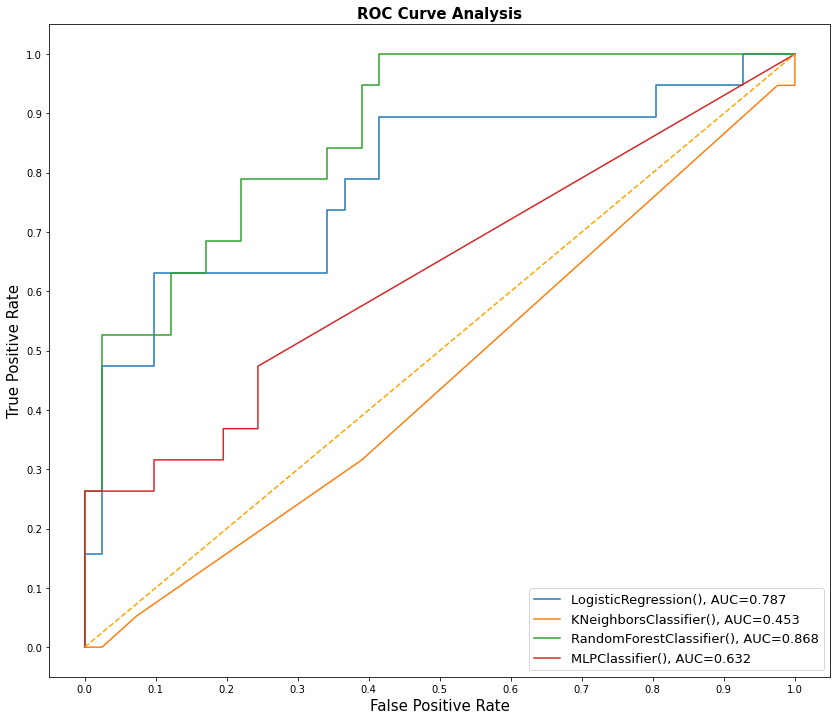

In [91]:
fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [84]:
for i in result_table.index:
        print('\n---- statistics for', i, '----\n')
        print(result_table.loc[i, 'clf_report'])
        print('Model log loss:', result_table.loc[i, 'log_loss'])


---- statistics for LogisticRegression() ----

              precision    recall  f1-score   support

           0       0.91      0.73      0.81        41
           1       0.59      0.84      0.70        19

    accuracy                           0.77        60
   macro avg       0.75      0.79      0.75        60
weighted avg       0.81      0.77      0.77        60

Model log loss: 0.5289079956572317

---- statistics for KNeighborsClassifier() ----

              precision    recall  f1-score   support

           0       0.68      0.98      0.80        41
           1       0.00      0.00      0.00        19

    accuracy                           0.67        60
   macro avg       0.34      0.49      0.40        60
weighted avg       0.46      0.67      0.55        60

Model log loss: 0.6733838662565156

---- statistics for RandomForestClassifier() ----

              precision    recall  f1-score   support

           0       0.85      0.80      0.83        41
           1     

#### All the models perform much worse with all columns in the dataset.